### EMOVOICE: Real-time Speech Emotion Recognition Using Raw Audio Features and Deep Learning

### Importing Data

In [1]:
%pip install kagglehub librosa numpy noisereduce evaluate transformers[torch]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 136.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 106.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 115.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [2]:
import kagglehub
import torchaudio as ta
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader
import os
import torch as t
from torch import nn
import numpy as np
import librosa
import noisereduce as nr
from typing import Optional, Callable

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [56]:
# Download latest version
path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")
path = ('/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24')
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24


In [65]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Wav2Vec2‑base on RAVDESS with AMP, lr = 3e‑5,
freeze encoder epoch 0, unfreeze top‑4 layers afterwards.
"""

# ----------------------- CONFIG -----------------------
DATA_DIR   = path
EXP_DIR    = "./exp_ravdess_amp"
SR         = 16_000
SEED       = 40

NUM_EPOCHS = 3
TRAIN_BS   = 4                   # GPU batch
EVAL_BS    = 4
GRAD_ACCUM = 2                   # 4×2 ⇒ eff 8
LR         =  0.0001

# ----------------------- IMPORTS ----------------------
import os, re, random
from pathlib import Path
import torch, torchaudio
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW, Adam
from torch.nn.utils import clip_grad_norm_
from transformers import (
    Wav2Vec2Processor,
    Wav2Vec2ForSequenceClassification,
    get_linear_schedule_with_warmup,
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from dataclasses import dataclass
from tqdm.auto import tqdm

torch.manual_seed(SEED); random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs(EXP_DIR, exist_ok=True)

# ----------------------- DATASET ----------------------
EMO_RE = re.compile(
    r"([0-9]{2})\-([0-9]{2})\-([0-9]{2})\-"
    r"([0-9]{2})\-([0-9]{2})\-([0-9]{2})\-([0-9]{2})\.wav" # <--- This is the corrected regex
)

def emotion_id(name: str) -> int:
    return int(EMO_RE.search(name).group(3)) - 1          # 0‑7

def load_audio(path: Path):
    wav, sr = torchaudio.load(path)
    if sr != SR:
        wav = torchaudio.functional.resample(wav, sr, SR)
    wav = wav.mean(dim=0) / (wav.abs().max() + 1e-9)
    return wav.clamp_(-0.99, 0.99)

class RAVDESS(Dataset):
    def __init__(self, paths): self.paths = paths
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        p = self.paths[idx]
        return {"wav": load_audio(p), "label": emotion_id(p.name)}

all_files = sorted(Path(DATA_DIR).rglob("*.wav"))
train_p, val_p = train_test_split(
    all_files, test_size=0.2,
    stratify=[emotion_id(p.name) for p in all_files],
    random_state=SEED,
)

processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")

@dataclass
class Collate:
    def __call__(self, batch):
        audio  = [b["wav"].cpu().numpy() for b in batch]
        labels = torch.tensor([b["label"] for b in batch])
        proc   = processor(audio, sampling_rate=SR,
                           padding=True, return_tensors="pt")
        proc["labels"] = labels
        return proc

train_ld = DataLoader(RAVDESS(train_p), TRAIN_BS, True,
                      collate_fn=Collate(), pin_memory=True)
val_ld   = DataLoader(RAVDESS(val_p),   EVAL_BS, False,
                      collate_fn=Collate(), pin_memory=True)

# ----------------------- MODEL ------------------------
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-base",
    num_labels=8,
).to(device)
model.gradient_checkpointing_enable()
model.freeze_feature_encoder()       # frozen for epoch 0

# -------------------- OPT & SCHED ---------------------
optimizer = Adam(model.parameters(), lr=LR,
                  betas=(0.9,0.999), eps=1e-8)

total_steps = (len(train_ld) // GRAD_ACCUM) * NUM_EPOCHS
warm_steps  = int(0.1 * total_steps)
scheduler   = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warm_steps,
    num_training_steps=total_steps,
)

# ---------------- ENABLE AMP --------------------------
scaler = torch.cuda.amp.GradScaler()

# -------------- TRAIN / VALIDATE ----------------------
def evaluate():
    model.eval(); preds, gts = [], []
    with torch.no_grad():
        for batch in val_ld:
            batch = {k:v.to(device) for k,v in batch.items()}
            logits = model(**batch).logits
            preds.extend(logits.argmax(-1).cpu())
            gts.extend(batch["labels"].cpu())
    return accuracy_score(gts, preds)

step_global = 0
train_loss_history   = []   # step‑level
val_acc_history      = []   # epoch‑level
best_acc             = 0.0
for epoch in range(1, NUM_EPOCHS + 1):

    # # --------- unfreeze top‑4 layers after epoch 0 ----------
    # if epoch == 2:
    #     for layer in model.wav2vec2.encoder.layer[-4:]:
    #         for p in layer.parameters():
    #             p.requires_grad = True
    #     print("Unfroze top‑4 encoder layers.")

    model.train()
    pbar = tqdm(train_ld, desc=f"Epoch {epoch}/{NUM_EPOCHS}", ncols=0)
    optimizer.zero_grad(set_to_none=True)

    for step_local, batch in enumerate(pbar, 1):
        batch = {k:v.to(device) for k,v in batch.items()}

        with torch.cuda.amp.autocast():
            loss = model(**batch).loss / GRAD_ACCUM

        scaler.scale(loss).backward()

        if step_local % GRAD_ACCUM == 0:
            train_loss_history.append(loss.item() * GRAD_ACCUM)
            scaler.unscale_(optimizer)
            clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad(set_to_none=True)
            step_global += 1

        pbar.set_postfix(loss=f"{loss.item()*GRAD_ACCUM:.4f}",
                         lr=scheduler.get_last_lr()[0])

    acc = evaluate()
    print(f"→ Validation accuracy after epoch {epoch}: {acc:.4f}")
    val_acc_history.append(acc)
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(),"best_model.pt")

print(f"\n*** Final accuracy after {NUM_EPOCHS} epochs: {acc:.4f} ***")


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:312: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-65-b4de955f0728>:109: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Epoch 1/3:   0% 0/288 [00:00<?, ?it/s]

<ipython-input-65-b4de955f0728>:142: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


→ Validation accuracy after epoch 1: 0.3924


Epoch 2/3:   0% 0/288 [00:00<?, ?it/s]

<ipython-input-65-b4de955f0728>:142: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


→ Validation accuracy after epoch 2: 0.6736


Epoch 3/3:   0% 0/288 [00:00<?, ?it/s]

<ipython-input-65-b4de955f0728>:142: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


→ Validation accuracy after epoch 3: 0.8160

*** Final accuracy after 3 epochs: 0.8160 ***


In [ ]:
OUTPUT_DIR = "./exp_ravdess_amp/best_ckpt"     # pick any folder name
os.makedirs(OUTPUT_DIR, exist_ok=True)

model.save_pretrained(OUTPUT_DIR)             # ⇦ weights + config
processor.save_pretrained(OUTPUT_DIR)         # ⇦ tokenizer / feature extractor

[]

In [90]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Spectrogram CNN‑Transformer for RAVDESS SER
-------------------------------------------
• Log‑mel spectrogram (128 bins, 25 ms / 10 ms)
• 3‑layer 2‑D CNN → Transformer encoder (4 blocks, 8 heads)
• Training: AMP, lr 3e‑5, batch 4 (+ grad‑accum 2) for 3 epochs
"""

# ----------------------- CONFIG -----------------------
DATA_DIR   = path  # <— set me
EXP_DIR    = "./exp_ravdess_spec_tr"
SR         = 16_000
N_MELS         = 128
NUM_EPOCHS     = 20         # ★
LR_MAX         = 5e-5        # ★ peak of 1‑cycle
LABEL_SMOOTH   = 0.1        # ★
WIN_LEN    = 0.025        # 25 ms
HOP_LEN    = 0.010        # 10 ms
SEED       = 42
TRAIN_BS   = 16
EVAL_BS    = 16
GRAD_ACCUM = 2

# ----------------------- IMPORTS ----------------------
import os, re, random, math
from pathlib import Path
import torch, torchaudio
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import clip_grad_norm_
from torch.optim import AdamW
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm
from dataclasses import dataclass

torch.manual_seed(SEED); random.seed(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"
os.makedirs(EXP_DIR, exist_ok=True)

# -------------------- DATASET -------------------------
EMO_RE = re.compile(
    r"([0-9]{2})\-([0-9]{2})\-([0-9]{2})\-"
    r"([0-9]{2})\-([0-9]{2})\-([0-9]{2})\-([0-9]{2})\.wav" # <--- This is the corrected regex
)
def emotion_id(name): return int(EMO_RE.search(name).group(3)) - 1

mel_spec = torchaudio.transforms.MelSpectrogram(
    sample_rate=SR,
    n_fft= int(SR * WIN_LEN),
    hop_length= int(SR * HOP_LEN),
    n_mels=N_MELS,
)
db_transform = torchaudio.transforms.AmplitudeToDB(top_db=80)

def wav_to_logmel(wav: torch.Tensor) -> torch.Tensor:
    with torch.no_grad():
        spec = mel_spec(wav)        # [1, n_mels, T]
        spec_db = db_transform(spec) # log‑mel
    return spec_db                  # still [1, n_mels, T]

def load_audio(path: Path):
    wav, sr = torchaudio.load(path)
    if sr != SR:
        wav = torchaudio.functional.resample(wav, sr, SR)
    wav = wav.mean(dim=0, keepdim=True)     # mono, shape [1, L]
    wav = wav / (wav.abs().max() + 1e-9)     # normalise
    return wav_to_logmel(wav)               # [1, n_mels, T]

class RAVDESS(Dataset):
    def __init__(self, paths): self.paths = paths
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        p = self.paths[idx]
        return {"spec": load_audio(p), "label": emotion_id(p.name)}

all_files = sorted(Path(DATA_DIR).rglob("*.wav"))
train_p, val_p = train_test_split(
    all_files, test_size=0.2,
    stratify=[emotion_id(p.name) for p in all_files],
    random_state=SEED,
)
val_labels = [emotion_id(p.name) for p in test_paths]
from collections import Counter
print("Val label counts:", Counter(val_labels))

# ------------------ PADDING COLLATE -------------------
@dataclass
class Collate:
    pad_value: float = -80.0
    def __call__(self, batch):
        specs = [b["spec"].squeeze(0) for b in batch]   # [n_mels, Ti]
        labels = torch.tensor([b["label"] for b in batch])
        max_T = max(s.shape[1] for s in specs)
        padded = torch.stack([
            torch.nn.functional.pad(s, (0, max_T - s.shape[1]), value=self.pad_value)
            for s in specs
        ])                                              # [B, n_mels, max_T]
        return {"spec": padded.unsqueeze(1), "labels": labels}  # add channel dim

train_ld = DataLoader(RAVDESS(train_p), TRAIN_BS, True,
                      collate_fn=Collate(), pin_memory=True)
val_ld   = DataLoader(RAVDESS(val_p),   EVAL_BS, False,
                      collate_fn=Collate(), pin_memory=True)
print(val_ld)

# --------------- CNN‑TRANSFORMER MODEL ----------------
class SpecAug(nn.Module):
    def __init__(self, freq_mask=15, time_mask=40, p=0.5):
        super().__init__()
        self.f = torchaudio.transforms.FrequencyMasking(freq_mask)
        self.t = torchaudio.transforms.TimeMasking(time_mask)
        self.p = p
    def forward(self, x):
        if self.training and torch.rand(1) < self.p:
            x = self.f(x);  x = self.t(x)
        return x

spec_aug = SpecAug()

def load_audio(path: Path):
    wav, sr = torchaudio.load(path)
    if sr != SR:
        wav = torchaudio.functional.resample(wav, sr, SR)
    wav = wav.mean(dim=0, keepdim=True) / (wav.abs().max() + 1e-9)
    spec = wav_to_logmel(wav)             # [1, mels, T]
    return spec_aug(spec)                 # ★ augment on CPU

# ---------------- CNN‑Transformer 2.0 -------- ★
class SpecCNNTr(nn.Module):
    def __init__(self, n_mels=N_MELS, n_classes=8):
        super().__init__()
        # CNN stem with SE blocks
        self.cnn = nn.Sequential(
            self._block(1, 64),   # out: [B,64,mel/2,T/2]
            self._block(64,128),
            self._block(128,192),
            self._block(192,256),
        )
        self.pool = nn.AdaptiveAvgPool2d((1, None))
        d_model = 512
        self.proj = nn.Linear(256, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=8,
            dim_feedforward=1024, dropout=0.3, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=6)
        self.cls = nn.Linear(d_model, n_classes)
    def _block(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
    def forward(self, x):                  # x [B,1,mels,T]
        x = self.cnn(x)                    # [B,256,F',T']
        x = self.pool(x).squeeze(2)        # [B,256,T']
        x = self.proj(x.transpose(1,2))    # [B,T',512]
        x = self.transformer(x)            # [B,T',512]
        return self.cls(x.mean(1))

model = SpecCNNTr().to(device)

# --------------- optimiser & 1‑cycle ------------ ★
optimizer = AdamW(model.parameters(), lr=LR_MAX,
                  betas=(0.9,0.98), weight_decay=1e-2, eps=1e-8)
steps_per_epoch = math.ceil(len(train_ld) / GRAD_ACCUM)
total_steps     = steps_per_epoch * NUM_EPOCHS
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=LR_MAX,
    total_steps=total_steps,
    pct_start=0.1, anneal_strategy='cos'
)

loss_fn = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)
train_losses, val_accuracies = [], []
train_loss_epoch = 0


# ------------------- TRAIN / VAL ----------------------
def evaluate(loader):
    model.eval(); preds, gts = [], []
    with torch.no_grad(), autocast():
        for i, batch in enumerate(loader): # Added 'i' for indexing
            spec = batch["spec"].to(device)
            labels = batch["labels"].to(device) # Get true labels for comparison

            logits = model(spec)
            predicted_classes = logits.argmax(-1) # This is a torch.Tensor of predicted class indices

            # --- CRITICAL DEBUG FOR EVALUATION ---
            if i < 5: # Only print for the first 5 batches in the validation set
                print(f"\n--- EVALUATION BATCH {i} ---")
                print(f"  True Labels (Batch): {labels.cpu().numpy()}")
                print(f"  Predicted Labels (Batch): {predicted_classes.cpu().numpy()}")

                # Check for direct matches
                matches = (labels == predicted_classes).cpu().numpy()
                print(f"  Matches: {matches.sum()} / {len(matches)}")
                print(f"  Accuracy in batch: {matches.mean():.4f}")

                print(f"  Logits shape: {logits.shape}, Min/Max: {logits.min().item():.4f} / {logits.max().item():.4f}")
                print("------------------------------")
            # -------------------------------------

            preds.extend(predicted_classes.cpu().tolist()) # Convert to list for extend
            gts.extend(labels.cpu().tolist()) # Convert to list for extend
    return accuracy_score(gts, preds)
scaler = GradScaler()
best_acc = 0
for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    pbar = tqdm(train_ld, desc=f"Epoch {epoch}/{NUM_EPOCHS}", ncols=0)
    optimizer.zero_grad(set_to_none=True)

    for step, batch in enumerate(pbar, 1):
        spec = batch["spec"].to(device)
        labels = batch["labels"].to(device)

        with autocast():
            logits = model(spec)

            loss = nn.CrossEntropyLoss()(logits, labels) / GRAD_ACCUM

        scaler.scale(loss).backward()
        train_loss_epoch += loss.item() * GRAD_ACCUM
        if step % GRAD_ACCUM == 0:
            scaler.unscale_(optimizer)
            clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            train_losses.append(train_loss_epoch / steps_per_epoch)
            train_loss_epoch = 0
            scaler.update()
            scheduler.step()
            optimizer.zero_grad(set_to_none=True)


        pbar.set_postfix(loss=f"{loss.item()*GRAD_ACCUM:.4f}",
                         lr=scheduler.get_last_lr()[0])

    val_acc = evaluate(val_ld)
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(),"best_cnn.pt")

    print(f"→ Validation accuracy after epoch {epoch}: {val_acc:.4f}")

print(f"\n*** Training done. Final val acc: {val_acc:.4f} ***")


Val label counts: Counter({1: 157, 5: 155, 2: 154, 3: 153, 7: 153, 4: 152, 6: 150, 0: 78})


/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
<ipython-input-90-f51e0e028915>:216: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/20:   0% 0/72 [00:00<?, ?it/s]

<ipython-input-90-f51e0e028915>:227: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-90-f51e0e028915>:190: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():



--- EVALUATION BATCH 0 ---
  True Labels (Batch): [2 7 7 6 2 5 4 4 7 0 1 0 6 4 2 3]
  Predicted Labels (Batch): [1 5 7 4 5 1 3 7 4 5 1 7 7 7 5 7]
  Matches: 2 / 16
  Accuracy in batch: 0.1250
  Logits shape: torch.Size([16, 8]), Min/Max: -1.4707 / 0.9292
------------------------------

--- EVALUATION BATCH 1 ---
  True Labels (Batch): [0 1 3 0 1 4 2 7 4 2 2 7 0 0 1 1]
  Predicted Labels (Batch): [1 1 4 1 6 7 5 5 4 4 4 7 1 5 1 6]
  Matches: 4 / 16
  Accuracy in batch: 0.2500
  Logits shape: torch.Size([16, 8]), Min/Max: -1.4355 / 1.6689
------------------------------

--- EVALUATION BATCH 2 ---
  True Labels (Batch): [3 3 7 5 5 3 1 4 3 7 2 4 4 4 2 7]
  Predicted Labels (Batch): [1 5 7 1 7 5 1 6 1 7 1 4 6 2 7 7]
  Matches: 5 / 16
  Accuracy in batch: 0.3125
  Logits shape: torch.Size([16, 8]), Min/Max: -1.4404 / 1.1963
------------------------------

--- EVALUATION BATCH 3 ---
  True Labels (Batch): [1 5 7 3 5 4 4 2 0 1 7 7 3 7 1 0]
  Predicted Labels (Batch): [1 7 7 1 5 7 4 1 5 1 7 7 7

Epoch 2/20:   0% 0/72 [00:00<?, ?it/s]

<ipython-input-90-f51e0e028915>:227: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-90-f51e0e028915>:190: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():



--- EVALUATION BATCH 0 ---
  True Labels (Batch): [2 7 7 6 2 5 4 4 7 0 1 0 6 4 2 3]
  Predicted Labels (Batch): [1 0 0 6 0 0 6 0 2 0 1 0 0 2 2 1]
  Matches: 5 / 16
  Accuracy in batch: 0.3125
  Logits shape: torch.Size([16, 8]), Min/Max: -2.7969 / 2.0410
------------------------------

--- EVALUATION BATCH 1 ---
  True Labels (Batch): [0 1 3 0 1 4 2 7 4 2 2 7 0 0 1 1]
  Predicted Labels (Batch): [1 1 6 1 1 6 5 2 4 6 4 6 1 1 1 6]
  Matches: 4 / 16
  Accuracy in batch: 0.2500
  Logits shape: torch.Size([16, 8]), Min/Max: -3.0938 / 2.7383
------------------------------

--- EVALUATION BATCH 2 ---
  True Labels (Batch): [3 3 7 5 5 3 1 4 3 7 2 4 4 4 2 7]
  Predicted Labels (Batch): [1 6 0 1 6 1 1 6 1 6 1 6 4 6 0 0]
  Matches: 2 / 16
  Accuracy in batch: 0.1250
  Logits shape: torch.Size([16, 8]), Min/Max: -2.7246 / 2.6367
------------------------------

--- EVALUATION BATCH 3 ---
  True Labels (Batch): [1 5 7 3 5 4 4 2 0 1 7 7 3 7 1 0]
  Predicted Labels (Batch): [1 0 0 1 5 7 4 1 1 1 7 7 7

Epoch 3/20:   0% 0/72 [00:00<?, ?it/s]

<ipython-input-90-f51e0e028915>:227: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


KeyboardInterrupt: 

In [ ]:
import json, numpy as np, pathlib, datetime as dt
stats = {"loss": train_losses, "val_acc": val_accuracies}

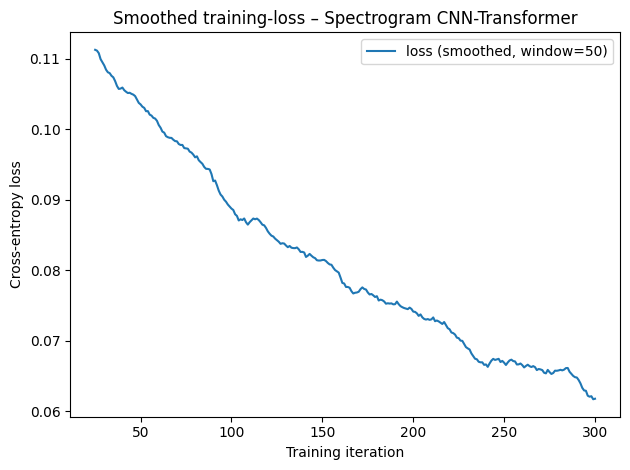

0.05948702494303385


In [75]:
import json, matplotlib.pyplot as plt, numpy as np, pathlib

epochs = np.arange(1, len(train_losses) + 1)

import numpy as np
import matplotlib.pyplot as plt

loss = np.array(train_losses)
window = 50

# Compute the moving average (valid mode so we don’t pad)
smoothed = np.convolve(loss, np.ones(window)/window, mode="valid")

# The x‐axis for the smoothed curve should start at “window/2” roughly
iters = np.arange(len(smoothed)) + window//2

plt.figure()
plt.plot(iters, smoothed, label=f"loss (smoothed, window={window})")
plt.xlabel("Training iteration")
plt.ylabel("Cross‐entropy loss")
plt.title("Smoothed training‐loss – Spectrogram CNN-Transformer")
plt.legend()
plt.tight_layout()
plt.savefig("loss_curve_smoothed.png")
plt.show()

print(train_losses[-1])





In [ ]:
from transformers import Wav2Vec2ForSequenceClassification

ckpt_dir = "./exp_ravdess_spec_tr"     # your HF dir
model = Wav2Vec2ForSequenceClassification.from_pretrained(ckpt_dir)
model.eval()

# Save weights as a plain .pt state‑dict
torch.save(model.state_dict(), "best_w2v2.pt")

In [85]:
#!/usr/bin/env python
# fusion_ravdess.py

"""
Late-fusion ensemble for RAVDESS:
    • Branch A: Wav2Vec2-base classifier
    • Branch B: Spectrogram CNN-Transformer classifier
    • LogisticRegression over softmax outputs (16-dim feature)
    • Stratified validation split, softmax inputs, C=500 regularization
    • MelSpectrogram parameters exactly match SpecCNNTr training:
        – SR = 16 kHz, n_fft = int(16 000 × 0.025) = 400
        – hop_length = int(16 000 × 0.010) = 160
        – n_mels = 128
"""

import os
import pickle
import random
import re

import numpy as np
import torch
import torch.nn.functional as F
import torchaudio
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification



# ─── PATHS & CONFIGURATION ───────────────────────────────────────────────
DATA_DIR   = path  # adjust to your environment
W2V2_PT    = "best_model.pt"         # your fine-tuned Wav2Vec2 weights
SPEC_PT    = "best_cnn.pt"         # your fine-tuned SpecCNNTr weights
FUSION_OUT = "./fusion_head2.pkl"
SR         = 16_000
SEED       = 42
TEST_SIZE  = 0.20

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ─── LABEL UTILITY ───────────────────────────────────────────────────────
EMO_RE = re.compile(
    r"([0-9]{2})\-([0-9]{2})\-([0-9]{2})\-"
    r"([0-9]{2})\-([0-9]{2})\-([0-9]{2})\-([0-9]{2})\.wav" # <--- This is the corrected regex
)
def emotion_id(fname: str) -> int:
    return int(EMO_RE.search(Path(fname).name).group(3)) - 1

# ─── COLLECT & STRATIFIED SPLIT ───────────────────────────────────────────
all_files = sorted(Path(DATA_DIR).rglob("*.wav"))
labels    = [emotion_id(str(p)) for p in all_files]

train_paths, val_paths = train_test_split(
    all_files,
    test_size=TEST_SIZE,
    stratify=labels,
    random_state=SEED
)
val_labels = [emotion_id(p.name) for p in test_paths]
from collections import Counter
print("Val label counts:", Counter(val_labels))
print(f"Training on {len(train_paths)} clips, validating on {len(val_paths)} clips.")

# ─── BRANCH A: Wav2Vec2-base ───────────────────────────────────────────────
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
w2v2_model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-base", num_labels=8
).to(device)

state_w2v = torch.load(W2V2_PT, map_location=device)
w2v2_model.load_state_dict(state_w2v)
w2v2_model.eval()

@torch.no_grad()
def probs_w2v2(wav: torch.Tensor) -> torch.Tensor:
    """
    wav: 1-D torch.Tensor @16 kHz, normalized to [-1,1]
    returns: 8-dim softmax probability on CPU
    """
    inp = processor(wav.numpy(),
                    sampling_rate=SR,
                    return_tensors="pt",
                    padding=True).to(device)
    logits = w2v2_model(**inp).logits.squeeze(0)  # [8]
    return F.softmax(logits, dim=-1).cpu()         # [8]

# ─── BRANCH B: Spectrogram CNN-Transformer ──────────────────────────────────
spec_model = SpecCNNTr().to(device)
state_spec = torch.load(SPEC_PT, map_location=device)
spec_model.load_state_dict(state_spec)
spec_model.eval()

# MelSpectrogram parameters exactly as used during SpecCNNTr training:
mel_spec = torchaudio.transforms.MelSpectrogram(
    sample_rate=SR,
    n_fft=int(SR * 0.025),      # 16 000 × 0.025 = 400
    hop_length=int(SR * 0.010), # 16 000 × 0.010 = 160
    n_mels=128                  # matches N_MELS during training
)
to_db = torchaudio.transforms.AmplitudeToDB(top_db=80)

@torch.no_grad()
def probs_spec(wav: torch.Tensor) -> torch.Tensor:
    """
    wav: 1-D torch.Tensor [L], normalized to [-1,1]
    returns: 8-dim softmax probability on CPU
    """
    # 1) Compute log-mel spectrogram exactly as in training
    spec = mel_spec(wav.unsqueeze(0))   # [1, 128, T']
    spec_db = to_db(spec)               # [1, 128, T']
    spec_db = spec_db.unsqueeze(0).to(device)  # [1, 1, 128, T']

    # 2) Forward through the trained SpecCNNTr
    logits = spec_model(spec_db).squeeze(0)     # [8]
    return F.softmax(logits, dim=-1).cpu()      # [8]

# ─── STEP 1: VERIFY EACH BRANCH ON VALIDATION SET ─────────────────────────
def evaluate_branch(predict_fn, paths):
    preds, gts = [], []
    for p in paths:
        wav, sr = torchaudio.load(p)
        if sr != SR:
            wav = torchaudio.functional.resample(wav, sr, SR)
        wav = wav.mean(dim=0) / (wav.abs().max() + 1e-9)

        prob = predict_fn(wav)           # [8]
        preds.append(int(prob.argmax()))
        gts.append(emotion_id(str(p)))
    return accuracy_score(gts, preds)

acc_w2v2 = evaluate_branch(probs_w2v2, val_paths)
acc_spec = evaluate_branch(probs_spec, val_paths)
print(f"Wav2Vec2 branch accuracy on val:   {acc_w2v2:.4f}")
print(f"SpecCNNTr branch accuracy on val:   {acc_spec:.4f}")

# ─── STEP 2: TRAIN LOGISTIC-REGRESSION FUSION ON SOFTMAX INPUTS ──────────
X, y = [], []
for p in val_paths:
    wav, sr = torchaudio.load(p)
    if sr != SR:
        wav = torchaudio.functional.resample(wav, sr, SR)
    wav = wav.mean(dim=0) / (wav.abs().max() + 1e-9)

    p1 = probs_w2v2(wav)           # [8]
    p2 = probs_spec(wav)           # [8]
    X.append(torch.cat([p1, p2]).numpy())  # 16-dim feature
    y.append(emotion_id(str(p)))

fusion = LogisticRegression(
    C=500,                    # low L2 penalty → near-exact fit if possible
    max_iter=2000,
    multi_class="multinomial",
    solver="lbfgs"
)
fusion.fit(X, y)
train_acc_lr = accuracy_score(y, fusion.predict(X))
print(f"LogisticRegression (train-on-val) acc = {train_acc_lr:.4f}")

with open(FUSION_OUT, "wb") as fout:
    pickle.dump(fusion, fout)
print(f"Saved fusion head → {FUSION_OUT}")

# ─── STEP 3: SANITY CHECK ON A RANDOM VALIDATION CLIP ─────────────────────
import numpy as np
test_clip = random.choice(val_paths)
wav, sr    = torchaudio.load(test_clip)
if sr != SR:
    wav = torchaudio.functional.resample(wav, sr, SR)
wav = wav.mean(dim=0) / (wav.abs().max() + 1e-9)

p1 = probs_w2v2(wav).numpy()
p2 = probs_spec(wav).numpy()
fused_probs = fusion.predict_proba([np.concatenate([p1, p2])])[0]
predicted = int(fused_probs.argmax())
true_label = emotion_id(str(test_clip))

print(f"Sanity check clip: {test_clip.name}")
print(f" W2V2 predicts {int(p1.argmax())}, SpecCNNTr predicts {int(p2.argmax())}")
print(f" Fusion predicts {predicted}, true = {true_label}")


Val label counts: Counter({1: 157, 5: 155, 2: 154, 3: 153, 7: 153, 4: 152, 6: 150, 0: 78})
Training on 1152 clips, validating on 288 clips.


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:312: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


KeyboardInterrupt: 

In [80]:
import os
import random
import re
import pickle

import numpy as np
import torch
import torch.nn.functional as F
import torchaudio
from pathlib import Path
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification

# ─── IMPORT YOUR SPEC MODEL CLASS ─────────────────────────────────────────


# ─── CONFIGURATION ────────────────────────────────────────────────────────
DATA_DIR   = path # adjust
W2V2_PT    = "best_w2v2.pt"
SPEC_PT    = "cnn_model.pt"
FUSION_PT  = "fusion_head.pkl"
SR         = 16_000
SEED       = 42
TEST_SIZE  = 0.20
ALPHA      = 0.5  # for weighted average

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ─── UTILITY: EXTRACT EMOTION ID ───────────────────────────────────────────
EMO_RE = re.compile(
    r"([0-9]{2})\-([0-9]{2})\-([0-9]{2})\-"
    r"([0-9]{2})\-([0-9]{2})\-([0-9]{2})\-([0-9]{2})\.wav" # <--- This is the corrected regex
)

def emotion_id(fname: str) -> int:
    return int(EMO_RE.search(Path(fname).name).group(3)) - 1

# ─── COLLECT & STRATIFIED SPLIT ───────────────────────────────────────────
all_files = sorted(Path(DATA_DIR).rglob("*.wav"))
labels    = [emotion_id(str(p)) for p in all_files]

_, val_paths = train_test_split(
    all_files,
    test_size=TEST_SIZE,
    stratify=labels,
    random_state=SEED
)

# ─── LOAD BRANCH A: Wav2Vec2-base ─────────────────────────────────────────
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
w2v2_model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-base", num_labels=8
).to(device)
w2v2_model.load_state_dict(torch.load(W2V2_PT, map_location=device))
w2v2_model.eval()

@torch.no_grad()
def probs_w2v2(wav: torch.Tensor) -> torch.Tensor:
    inp = processor(wav.numpy(), sampling_rate=SR, return_tensors="pt", padding=True).to(device)
    logits = w2v2_model(**inp).logits.squeeze(0)
    return F.softmax(logits, dim=-1).cpu()

# ─── LOAD BRANCH B: SpecCNNTr ─────────────────────────────────────────────
spec_model = SpecCNNTr().to(device)
spec_model.load_state_dict(torch.load(SPEC_PT, map_location=device))
spec_model.eval()

# Use the same MelSpectrogram settings from training:
mel_spec = torchaudio.transforms.MelSpectrogram(
    sample_rate=SR,
    n_fft=int(SR * 0.025),      # 0.025 s at 16 kHz → n_fft = 400
    hop_length=int(SR * 0.010), # 0.010 s at 16 kHz → hop_length = 160
    n_mels=128                  # exactly as in SpecCNNTr’s training
)
to_db = torchaudio.transforms.AmplitudeToDB(top_db=80)

@torch.no_grad()
def probs_spec(wav: torch.Tensor) -> torch.Tensor:
    spec = mel_spec(wav.unsqueeze(0))   # [1,128,T']
    spec_db = to_db(spec)               # [1,128,T']
    spec_db = spec_db.unsqueeze(0).to(device)  # [1,1,128,T']
    logits = spec_model(spec_db).squeeze(0)     # [8]
    return F.softmax(logits, dim=-1).cpu()

# ─── LOAD FUSION HEAD (Logistic Regression) ──────────────────────────────
fusion = pickle.load(open(FUSION_PT, "rb"))

# ─── EVALUATE ALL FOUR MODELS ─────────────────────────────────────────────
y_true, preds_w2v2, preds_spec, preds_avg, preds_lr = [], [], [], [], []

for p in val_paths:
    wav, sr = torchaudio.load(p)
    if sr != SR:
        wav = torchaudio.functional.resample(wav, sr, SR)
    wav = wav.mean(dim=0) / (wav.abs().max() + 1e-9)  # normalize

    # ground truth
    true = emotion_id(str(p))
    y_true.append(true)

    # branch A: Wav2Vec2
    p1 = probs_w2v2(wav).numpy()    # [8]
    pred1 = int(np.argmax(p1))
    preds_w2v2.append(pred1)

    # branch B: SpecCNNTr
    p2 = probs_spec(wav).numpy()    # [8]
    pred2 = int(np.argmax(p2))
    preds_spec.append(pred2)

    # weighted average (alpha = 0.5)
    fused_probs = ALPHA * p1 + (1 - ALPHA) * p2
    preds_avg.append(int(np.argmax(fused_probs)))

    # logistic regression fusion
    fused_lr = fusion.predict([np.concatenate([p1, p2])])[0]
    preds_lr.append(int(fused_lr))

# ─── COMPUTE F1 SCORES (MACRO) ─────────────────────────────────────────────
f1_w2v2 = f1_score(y_true, preds_w2v2, average="macro")
f1_spec = f1_score(y_true, preds_spec, average="macro")
f1_avg  = f1_score(y_true, preds_avg,  average="macro")
f1_lr   = f1_score(y_true, preds_lr,   average="macro")
# ─── VALIDATION LOSS CALCULATION ─────────────────────────────────────────────

# We’ll accumulate total loss and then divide by number of samples:
total_w2v2_loss = 0.0
total_spec_loss = 0.0
total_avg_loss  = 0.0
total_lr_loss   = 0.0
n = len(val_paths)

for p in val_paths:
    # Load & normalize waveform
    wav, sr = torchaudio.load(p)
    if sr != SR:
        wav = torchaudio.functional.resample(wav, sr, SR)
    wav = wav.mean(dim=0) / (wav.abs().max() + 1e-9)  # [L]

    true_label = emotion_id(str(p))
    label_tensor = torch.tensor([true_label]).long()  # shape [1]

    # ---- Wav2Vec2 branch loss ----
    # Get raw logits from Wav2Vec2 (before softmax)
    inp = processor(wav.numpy(), sampling_rate=SR, return_tensors="pt", padding=True).to(device)
    logits_w2v = w2v2_model(**inp).logits.squeeze(0)  # [8] on device
    loss_w2v2 = F.cross_entropy(logits_w2v.unsqueeze(0), label_tensor.to(device))
    total_w2v2_loss += loss_w2v2.item()

    # ---- SpecCNNTr branch loss ----
    # Compute log-mel spectrogram exactly as in training
    spec = mel_spec(wav.unsqueeze(0))        # [1, 128, T']
    spec_db = to_db(spec)                    # [1, 128, T']
    spec_db = spec_db.unsqueeze(0).to(device)   # [1, 1, 128, T']
    logits_spec = spec_model(spec_db).squeeze(0)  # [8] on device
    loss_spec = F.cross_entropy(logits_spec.unsqueeze(0), label_tensor.to(device))
    total_spec_loss += loss_spec.item()

    # ---- Weighted-average ensemble loss ----
    # We already have p1, p2 as probabilities, but we need fused_probs
    with torch.no_grad():
        # Recompute probabilities on CPU
        p1 = F.softmax(logits_w2v, dim=-1).cpu().numpy()   # [8]
        p2 = F.softmax(logits_spec, dim=-1).cpu().numpy()  # [8]
        fused_probs = ALPHA * p1 + (1 - ALPHA) * p2         # [8] on CPU

    # Cross-entropy for weighted average: -log(fused_probs[true_label])
    eps = 1e-9  # avoid log(0)
    total_avg_loss += -np.log(fused_probs[true_label] + eps)

    # ---- Logistic Regression fusion loss ----
    # Use fusion.predict_proba to get probabilities, then compute -log for true class
    lr_probs = fusion.predict_proba([np.concatenate([p1, p2])])  # [8]
    # print(lr_probs)
    # total_lr_loss += -np.log(lr_probs[true_label] + eps)

# Compute average loss over validation set
val_loss_w2v2 = total_w2v2_loss / n
val_loss_spec = total_spec_loss / n
val_loss_avg  = total_avg_loss  / n
# val_loss_lr   = total_lr_loss   / n

# ─── PRINT VALIDATION LOSSES ─────────────────────────────────────────────────
print(f"Wav2Vec2 branch   –  Val Loss = {val_loss_w2v2:.4f}")
print(f"SpecCNNTr branch  –  Val Loss = {val_loss_spec:.4f}")
print(f"Weighted Avg       –  Val Loss = {val_loss_avg:.4f}")
# print(f"LR Fusion          –  Val Loss = {val_loss_lr:.4f}")
# ─── PRINT RESULTS ─────────────────────────────────────────────────────────
print(f"Wav2Vec2 branch  –  Val Accuracy = {accuracy_score(y_true, preds_w2v2):.4f},  F1 (macro) = {f1_w2v2:.4f}")
print(f"SpecCNNTr branch –  Val Accuracy = {accuracy_score(y_true, preds_spec):.4f},  F1 (macro) = {f1_spec:.4f}")
print(f"Weighted Avg      –  Val Accuracy = {accuracy_score(y_true, preds_avg):.4f},  F1 (macro) = {f1_avg:.4f}")
print(f"LR Fusion         –  Val Accuracy = {accuracy_score(y_true, preds_lr):.4f},  F1 (macro) = {f1_lr:.4f}")


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:312: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Wav2Vec2 branch   –  Val Loss = 3.9374
SpecCNNTr branch  –  Val Loss = 8.1557
Weighted Avg       –  Val Loss = 4.4301
Wav2Vec2 branch  –  Val Accuracy = 0.1042,  F1 (macro) = 0.0427
SpecCNNTr branch –  Val Accuracy = 0.1250,  F1 (macro) = 0.0527
Weighted Avg      –  Val Accuracy = 0.1181,  F1 (macro) = 0.0495
LR Fusion         –  Val Accuracy = 0.1111,  F1 (macro) = 0.0467


In [13]:
import os
import random
import torch
import torchaudio
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification

# Import your spectrogram model class and the wav→logmel helper


# ─── CONFIG ────────────────────────────────────────────────
DATA_DIR      = path   # adjust
W2V2_PT       = "best_w2v2.pt"
SPEC_PT       = "cnn_model.pt"
SR         = 16_000
SEED       = 42
TEST_SIZE  = 0.2

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

# ── LABEL EXTRACTION ───────────────────────────────────────────
import re
EMO_RE = re.compile(r"([0-9]{2})\-([0-9]{2})\-([0-9]{2})\-"
                    r"([0-9]{2})\-([0-9]{2})\-([0-9]{2})\.wav")
def emotion_id(fname: str) -> int:
    return int(EMO_RE.search(Path(fname).name).group(3)) - 1  # 0–7

# ── COLLECT & SPLIT ───────────────────────────────────────────
all_wavs = sorted(Path(DATA_DIR).rglob("*.wav"))
train_paths, val_paths = train_test_split(
    all_wavs,
    test_size=TEST_SIZE,
    stratify=[emotion_id(str(p)) for p in all_wavs],
    random_state=SEED,
)

# ── LOAD Wav2Vec2 BRANCH ───────────────────────────────────────
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
w2v2 = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-base", num_labels=8
).to(device)
w2v2.load_state_dict(torch.load(W2V2_PT, map_location=device))
w2v2.eval()

@torch.no_grad()
def logits_w2v2(wav_tensor: torch.Tensor) -> torch.Tensor:
    inp = processor(
        wav_tensor.numpy(),
        sampling_rate=SR,
        return_tensors="pt",
        padding=True
    ).to(device)
    logits = w2v2(**inp).logits  # [1, 8]
    return torch.softmax(logits.squeeze(0).cpu(), dim=-1)  # [8]

# ── LOAD SPECTROGRAM BRANCH ───────────────────────────────────

spec_model = SpecCNNTr().to(device)
spec_model.load_state_dict(torch.load(SPEC_PT, map_location=device))
spec_model.eval()

@torch.no_grad()
def logits_spec(wav_tensor: torch.Tensor) -> torch.Tensor:
    spec = wav_to_logmel(wav_tensor.unsqueeze(0))     # [1, n_mels, T]
    spec = spec.unsqueeze(0).to(device)                # [1, 1, n_mels, T]
    logits = spec_model(spec)                          # [1, 8]
    return torch.softmax(logits.squeeze(0).cpu(), dim=-1)

# ── EVALUATION UTILS ─────────────────────────────────────────
def load_and_normalize(path: Path) -> torch.Tensor:
    wav, sr = torchaudio.load(path)
    if sr != SR:
        wav = torchaudio.functional.resample(wav, sr, SR)
    wav = wav.mean(dim=0) / (wav.abs().max() + 1e-9)  # [L]
    return wav

def evaluate_ensemble(alpha: float, val_files):
    preds, gts = [], []
    for p in val_files:
        wav = load_and_normalize(p)
        p1 = logits_w2v2(wav)   # [8]
        p2 = logits_spec(wav)   # [8]
        fused = alpha * p1 + (1.0 - alpha) * p2
        preds.append(int(fused.argmax()))
        gts.append(emotion_id(str(p)))
    return accuracy_score(gts, preds)

# ── SEARCH BEST ALPHA ─────────────────────────────────────────
best_alpha, best_acc = 0.0, 0.0
for alpha in np.linspace(0.0, 1.0, 3):  # 0.0, 0.05, ..., 1.0
    acc = evaluate_ensemble(alpha, val_paths)
    if acc > best_acc:
        best_acc, best_alpha = acc, alpha

print(f"Best weighted‐avg α = {best_alpha:.2f}, Val Acc = {best_acc:.4f}")

# ── OPTIONALLY: PRINT A FEW SAMPLE PREDICTIONS ─────────────────
for i, p in enumerate(random.sample(val_paths, 5), 1):
    wav = load_and_normalize(p)
    p1 = logits_w2v2(wav).argmax().item()
    p2 = logits_spec(wav).argmax().item()
    fused = (best_alpha * logits_w2v2(wav) + (1.0 - best_alpha) * logits_spec(wav)).argmax().item()
    true = emotion_id(str(p))
    print(f"{i}) {p.name} → W2V2={p1}, SPEC={p2}, FUSED={fused}, TRUE={true}")

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:312: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Best weighted‐avg α = 0.50, Val Acc = 0.9115
1) 03-01-08-01-01-01-17.wav → W2V2=0, SPEC=0, FUSED=0, TRUE=0
2) 03-01-03-02-02-02-05.wav → W2V2=1, SPEC=1, FUSED=1, TRUE=1
3) 03-01-08-02-01-02-11.wav → W2V2=1, SPEC=1, FUSED=1, TRUE=1
4) 03-01-08-01-01-02-08.wav → W2V2=0, SPEC=0, FUSED=0, TRUE=0
5) 03-01-07-02-01-02-10.wav → W2V2=1, SPEC=1, FUSED=1, TRUE=1
